# Instructions
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


### Start Notebook environment

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
# %load ../utility/overhead.py
#record module versions used in cell 1
#
def version_recorder():
    '''
    only works if import is first cell run. prints and then returns dictionary with modules:version.
    '''
    import pkg_resources
    resources = In[1].splitlines()
    ##ADD: drop lines if not _from_ or _import_
    version_dict = { resource.split()[1].split(".")[0] : pkg_resources.get_distribution(resource.split()[1].split(".")[0]).version for resource in resources }
    return version_dict
version_recorder()

{'numpy': '1.16.2',
 'pandas': '0.24.2',
 'sklearn': '0.0',
 'statsmodels': '0.10.1',
 'matplotlib': '3.0.3',
 'seaborn': '0.9.0',
 'sqlalchemy': '1.3.5'}

# Data Cleaning

In [3]:
#credentials
user = 'dsbc_student'
pw = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
db = 'houseprices'
dialect = 'postgresql'

db_addr = f'{dialect}://{user}:{pw}@{host}:{port}/{db}'
engine = create_engine(db_addr)

query = '''
SELECT
    *
FROM
    houseprices
'''

raw_df = pd.read_sql(query, con=engine)
engine.dispose()

In [4]:
house_df = raw_df.copy(deep=True)
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
house_df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [6]:
house_df.columns[house_df.dtypes != 'object']

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

In [7]:
#deal with nulls
for col in house_df.columns[house_df.dtypes != 'object']:
    house_df[col] = house_df[col].fillna(house_df[col].mean(), axis=0)

In [8]:
house_df.corr()["saleprice"].abs().sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.475241
garageyrblt      0.470177
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
id               0.021917
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: salepr

In [9]:
#create df with categorical variables to select some features from
categorical_feat = house_df.dtypes[house_df.dtypes == 'object'].index
new_categories_df = house_df[["saleprice"]]
for feature in categorical_feat:
    new_categories_df = pd.concat([new_categories_df, 
                                   pd.get_dummies(house_df[feature], columns=categorical_feat, drop_first=True, prefix = feature)], axis=1)

In [10]:
new_categories_df.corr()[["saleprice"]].abs().sort_values(by='saleprice', ascending=False).head(20)

,saleprice
saleprice,1.000000
exterqual_TA,0.589044
kitchenqual_TA,0.519298
foundation_PConc,0.497734
exterqual_Gd,0.452466
bsmtqual_TA,0.452394
bsmtfintype1_GLQ,0.434597
garagefinish_Unf,0.410608
neighborhood_NridgHt,0.402149
masvnrtype_None,0.374468


In [11]:
#append numerical features to new df
new_categories_df = pd.concat([new_categories_df.loc[:, new_categories_df.columns != 'saleprice'], 
                               house_df.filter(items=(house_df.columns[(house_df.dtypes.values != 'object').tolist()]), axis=1)], 
                              axis=1) #tolist() needed to avoid hashability issue

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

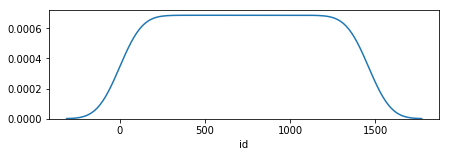

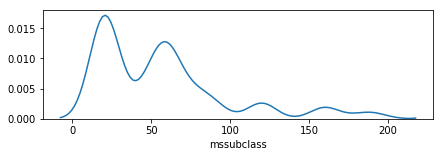

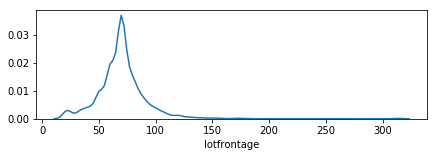

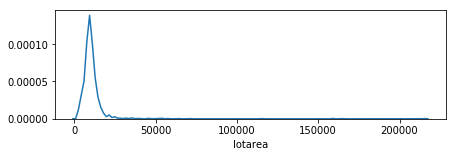

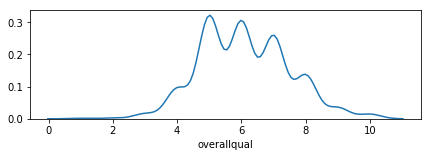

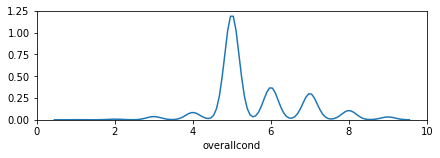

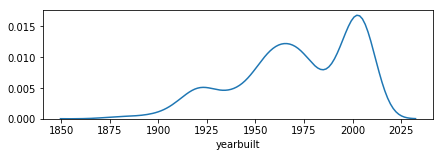

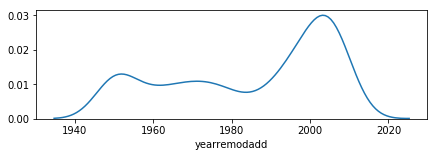

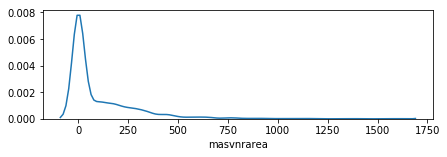

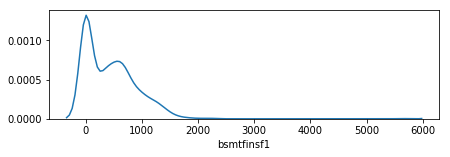

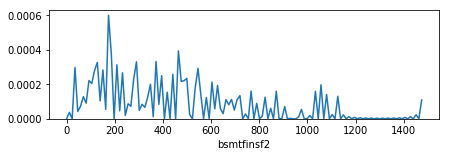

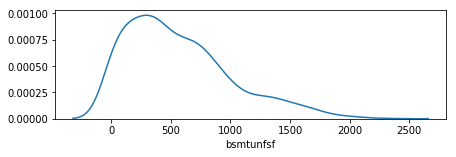

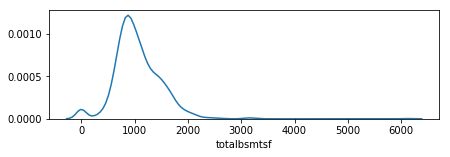

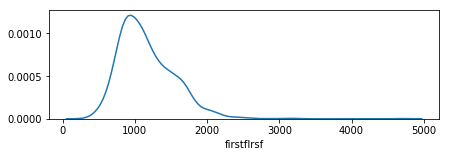

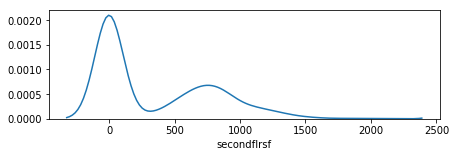

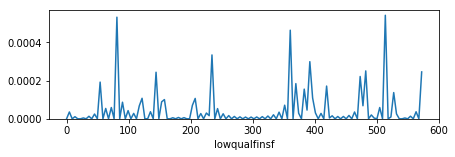

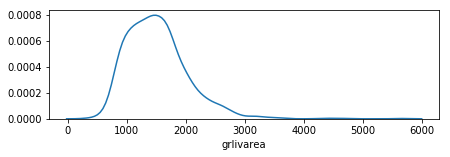

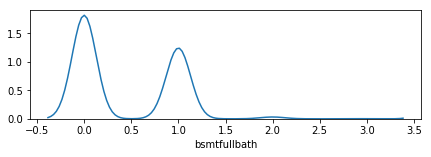

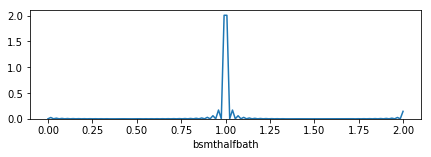

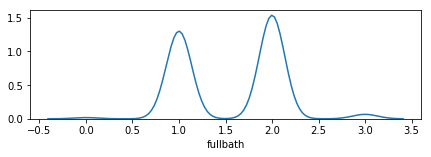

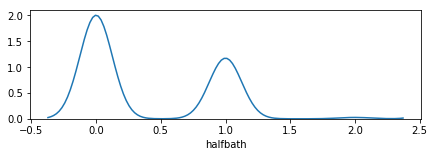

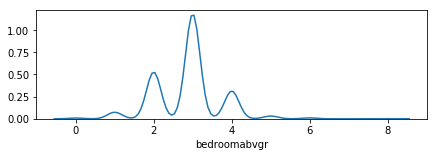

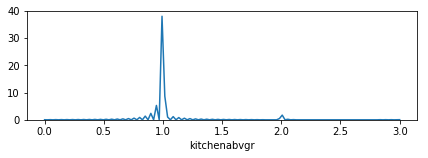

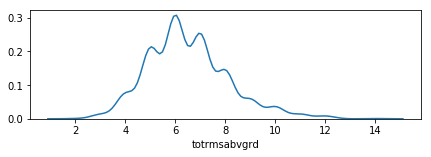

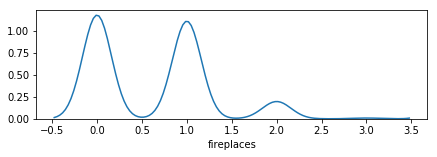

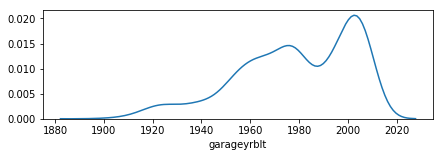

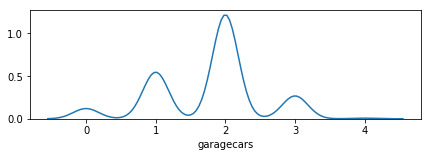

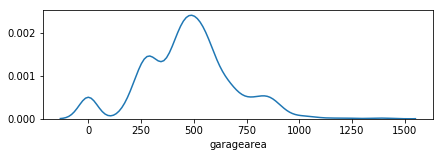

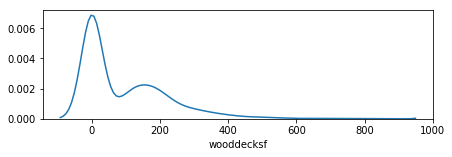

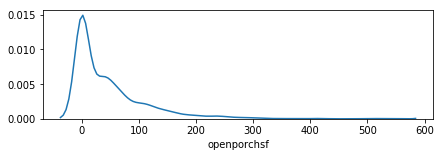

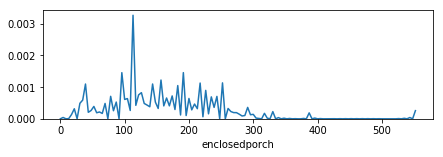

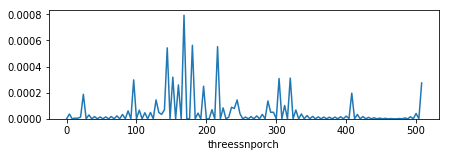

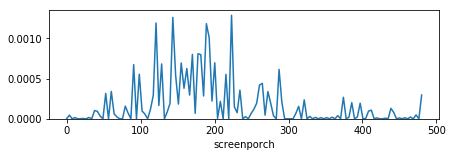

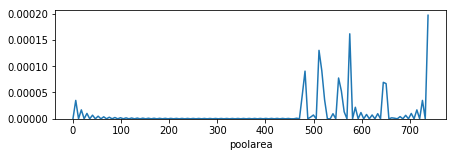

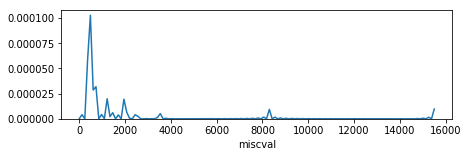

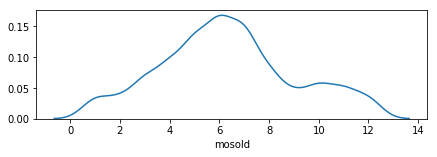

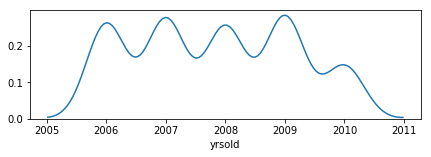

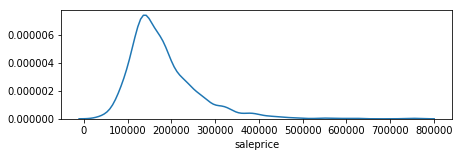

In [12]:
#review distributions of variables
# categorical features have Bernoulli distribution
for i, col in enumerate(house_df.filter(items=(house_df.columns[(house_df.dtypes.values != 'object').tolist()]), axis=1)):
    plt.figure(i)
    plt.figure(figsize=(7,2))
    sns.distplot(new_categories_df[col], hist=False);

Based on these, `lotarea`, `masvnrarea`, `totalbsmtsf`, & `miscval` need to be winsorized.

In [13]:
# %load ../../utility/numerical.py
#!/usr/bin/env python
def winsorize(data=[], lower=.05, upper=.95):
    '''Winsorizes an array. Defaults are at .05 and .95 of unit rank. 
    '''
    pcts = np.percentile(data, q=[lower, upper])
    w_ized = []
    for i in data:
        if i<pcts[0]:
            w_ized.append(pcts[0])
        elif i>pcts[1]:
            w_ized.append(pcts[1])
        else: 
            w_ized.append(i)
    return w_ized
w_list = ['lotarea', 'masvnrarea', 'totalbsmtsf', 'miscval']
for i in w_list:
    new_categories_df[i] = winsorize(new_categories_df[i], lower=0, upper=.95)

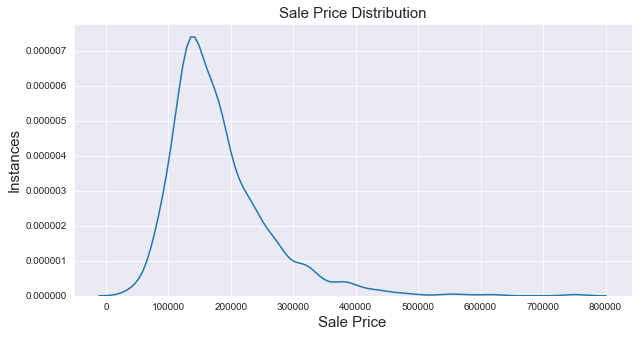

In [14]:
# view saleprice dist
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 5))
dp = sns.distplot(new_categories_df.saleprice, hist=False)
plt.ylabel('Instances', fontsize=15)
plt.xlabel('Sale Price', fontsize=15)
plt.title('Sale Price Distribution', fontsize=15);

In [15]:
#This is right skewed. Lets normalize 
new_categories_df["log_saleprice"] = np.log(new_categories_df.saleprice)

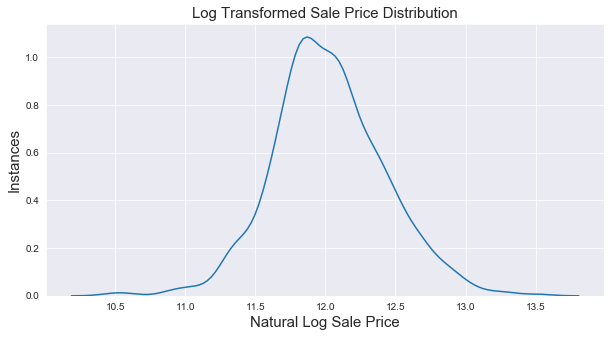

In [16]:
fig2 = plt.figure(figsize=(10,5))
dp2 = sns.distplot(new_categories_df.log_saleprice, hist=False)
plt.ylabel('Instances', fontsize=15)
plt.xlabel('Natural Log Sale Price', fontsize=15)
plt.title('Log Transformed Sale Price Distribution', fontsize=15);

In [17]:
pwd

'C:\\Users\\Chris\\Documents\\thinkful\\thinkful_notes\\Unit_2_supervised_learning\\19'

In [18]:
def corr_finder(df, min=.65):
    dfcorr = df.corr()
    filtered = dfcorr[(dfcorr.abs() > min) & ~(dfcorr == 1)]
    for i, row in filtered.iterrows():
        if row.sum() > 0: 
            print("--->{} is correlated with: ".format(i), end = '') 
            for ind, col in row.iteritems():
                if ~np.isnan(col):
                    print("    {} at {}".format(ind, col))


In [19]:
#create X & y
feature_list = new_categories_df.corr()[['saleprice']].abs().sort_values(by='saleprice', ascending=False).head(20)
corr_finder(new_categories_df[feature_list.index], min=.5)

--->saleprice is correlated with:     log_saleprice at 0.9483737306090593
    overallqual at 0.7909816005838048
    grlivarea at 0.7086244776126511
    garagecars at 0.640409197258349
    garagearea at 0.6234314389183598
    firstflrsf at 0.6058521846919166
    exterqual_TA at -0.5890435234097631
    fullbath at 0.5606637627484452
    totrmsabvgrd at 0.5337231555820237
    yearbuilt at 0.5228973328794967
    kitchenqual_TA at -0.5192978536548846
    yearremodadd at 0.5071009671113867
--->log_saleprice is correlated with:     saleprice at 0.9483737306090593
    overallqual at 0.8171844179216822
    grlivarea at 0.7009266525441293
    garagecars at 0.6806248074360438
    garagearea at 0.6508875559020062
    firstflrsf at 0.596981045034374
    exterqual_TA at -0.5958814190862858
    fullbath at 0.5947705420075314
    totrmsabvgrd at 0.5344222037231195
    yearbuilt at 0.5865702403842263
    kitchenqual_TA at -0.5382371448464456
    yearremodadd at 0.5656078325911801
    foundation_PConc a

In [46]:
# pick features from correlation func output
X = new_categories_df[["overallqual", "grlivarea", "garagecars", "totalbsmtsf", "firstflrsf", "exterqual_TA", 
              "fullbath", "totrmsabvgrd", "yearbuilt", "kitchenqual_TA", "yearremodadd", "yrsold"]]
X["overalqual_x_year"] = new_categories_df.overallqual * new_categories_df.yearbuilt
y = new_categories_df.log_saleprice

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


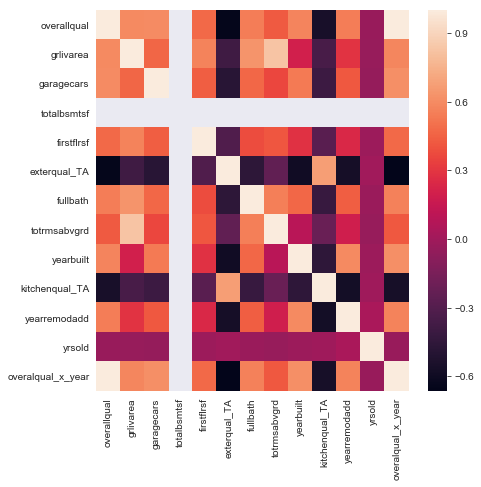

In [47]:
#check for correlations on reduced feature set
fig = plt.figure(figsize=(7,7))
ax = sns.heatmap(X.corr());

# Model Comparison
## Split data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [49]:
X_trainsm = sm.add_constant(X_train)
linear_m = sm.OLS(y_train, X_trainsm).fit()
linear_m.summary()

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     494.5
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        01:26:12   Log-Likelihood:                 479.57
No. Observations:                1168   AIC:                            -933.1
Df Residuals:                    1155   BIC:                            -867.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.6071      7.376      0.489      0.625     -10.866      18.080
overallqual           0.6515      0.246      2.646      0.008       0.168       1.135
grlivarea             0.0003   2.04e-05     12.785      0.000       0.000       0.000
garagecars            0.0714      0.009      8.147      0.000       0.054       0.089
totalbsmtsf       -5.869e-11    1.2e-10     -0.489      0.625   -2.94e-10    1.77e-10
firstflrsf            0.0002   1.59e-05     10.629      0.000       0.000       0.000
exterqual_TA          0.0158      0.016      0.974      0.330      -0.016       0.048
fullbath             -0.0347      0.013     -2.695      0.007      -0.060      -0.009
totrmsabvgrd         -0.0005      0.005     -0.086      0.931      -0.011       0.010
yearbuilt             0.0039      0.001      5.061      0.000       0.002       0.005
kitchenqual_TA       -0.0332      0.014     -2.359      0.019      -0.061      -0.006
yearremodadd          0.0018      0.000      5.598      0.000       0.001       0.002
yrsold               -0.0021      0.004     -0.587      0.557      -0.009       0.005
overalqual_x_year    -0.0003      0.000     -2.252      0.025      -0.001   -3.63e-05
==============================================================================
Omnibus:                      459.175   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5299.547
Skew:                          -1.481   Prob(JB):                         0.00
Kurtosis:                      13.006   Cond. No.                     7.93e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.14e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
linear_m.params.abs().sort_values(ascending=False)

const                3.607079e+00
overallqual          6.514892e-01
garagecars           7.135445e-02
fullbath             3.472944e-02
kitchenqual_TA       3.317923e-02
exterqual_TA         1.580634e-02
yearbuilt            3.935311e-03
yrsold               2.101157e-03
yearremodadd         1.835847e-03
totrmsabvgrd         4.562719e-04
overalqual_x_year    2.818106e-04
grlivarea            2.607107e-04
firstflrsf           1.694731e-04
totalbsmtsf          5.869294e-11
dtype: float64

The features `totalbsmtsf`, `totrmsabvgrd`, `exterqual_TA`, `yrsold` are not significant (p>.1). `totalbsmtsf` has very small parameters (e^x x<-04). We will eliminate all of them from the model. 

In [51]:
col_drop_lst = ['totalbsmtsf', 'totrmsabvgrd', 'exterqual_TA', 'yrsold', 'totalbsmtsf']
y_train = y_train.drop(columns=col_drop_lst)
y_test = y_test.drop(columns=col_drop_lst)

## Lasso

In [52]:
lasso_model = Lasso(tol=.5)  #increased tol to avoid 'ConvergenceWarning: Objective did not converge'
alphas = np.array([.0001, .001, .01, .1, 1, 10, 100, 1_000, 10_000, 100_000])

grid_las = GridSearchCV(estimator=lasso_model, param_grid=dict(alpha=alphas), cv=12)
grid_las.fit(X_train, y_train)
print(grid_las)
print("best r^2 is: {}".format(grid_las.best_score_))
print("associated lambda value is: {}".format(grid_las.best_estimator_.alpha))

GridSearchCV(cv=12, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.5, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
best r^2 is: 0.8104036656942001
associated lambda value is: 0.01


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Ridge

In [53]:
ridge_model = Ridge()
alphas = np.array([.0001, .001, .01, .1, 1, 10, 100, 1_000, 10_000, 100_000])

grid_ridge = GridSearchCV(estimator=ridge_model, param_grid=dict(alpha=alphas), cv=7)
grid_ridge.fit(X_train, y_train)
print(grid_ridge)
print("best r^2 is: {}".format(grid_ridge.best_score_))
print("associated lambda value is: {}".format(grid_ridge.best_estimator_.alpha))

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
best r^2 is: 0.8285316642667188
associated lambda value is: 0.1


## ElasticNet

In [54]:
elasticnet_model = ElasticNet(tol=1)   #increased tol to avoid 'ConvergenceWarning: Objective did not converge'
alphas = np.array([.0001, .001, .01, .1, 1, 10, 100])
l1_ratio = np.array([.1, .5, .9])
params = {'alpha': alphas, 'l1_ratio': l1_ratio}

grid_enet = GridSearchCV(estimator=elasticnet_model, param_grid=params, cv=7)
grid_enet.fit(X_train, y_train)
print(grid_enet)
print("best r^2 is: {}".format(grid_enet.best_score_))
print("associated lambda value is: {}".format(grid_enet.best_estimator_.alpha))
print("associated estimator value is: {}".format(grid_enet.best_estimator_))

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic', tol=1,
                                  warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': array([0.1, 0.5, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
best r^2 is: 0.819250207473064
associated lambda value is: 0.1
associated estimator value is: ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, select

# External Factors

Realtors may cite Location, Location, Location, but timing is vital when buying and selling assets. The Great Recession had a huge impact on the housing market (and vice-versa.) I am including a feature for the economic condition: annual unemployment rate.

I have also included interest rate. Most houses are purchased via mortgage and so, for a given monthly budget, a higher interest rate will result in a lower possible purchase price budget.

Citations:
Organization for Economic Co-operation and Development, Unemployment Rate: Aged 15-64: All Persons for the United States [LRUN64TTUSA156S], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/LRUN64TTUSA156S, August 6, 2019.

Freddie Mac, 30-Year Fixed Rate Mortgage Average in the United States [MORTGAGE30US], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MORTGAGE30US, August 7, 2019.

In [55]:
econ_df = pd.read_csv(r'../../../data_sets/LRUN64TTUSA156S.csv')

In [56]:
econ_df.DATE = pd.to_datetime(econ_df["DATE"])

In [57]:
econ_df["year"] = econ_df.DATE.dt.year
econ_df.head()

,DATE,LRUN64TTUSA156S,year
0,1960-01-01,5.617115,1960
1,1961-01-01,6.770271,1961
2,1962-01-01,5.596210,1962
3,1963-01-01,5.739126,1963
4,1964-01-01,5.246175,1964


In [58]:
econ2_df = pd.read_csv(r'../../../data_sets/MORTGAGE30US.csv')

In [59]:
econ2_df.head()

,DATE,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [60]:
#get annual interest rate average
econ2_df["year"] = pd.to_datetime(econ2_df.DATE).dt.year
econ_rates_df = econ2_df.groupby("year").mean()
econ_rates_df.head()

,MORTGAGE30US
year,
1971,7.541750
1972,7.383269
1973,8.044808
1974,9.187115
1975,9.047115


In [61]:
econ_both_df = pd.merge(left=econ_df, right=econ_rates_df, on='year').drop(["DATE"], axis=1)
econ_both_df = econ_both_df.rename(columns={'LRUN64TTUSA156S':'unemployment', 'MORTGAGE30US':'mtg_rate'})
econ_both_df.head()

,unemployment,year,mtg_rate
0,6.041505,1971,7.541750
1,5.688501,1972,7.383269
2,4.950751,1973,8.044808
3,5.677059,1974,9.187115
4,8.561464,1975,9.047115


In [62]:
#combine econ data with house data 
X_wecon_train = pd.merge(left=X_train, right=econ_both_df, left_on='yrsold', right_on='year', how='left')
X_wecon_test = pd.merge(left=X_test, right=econ_both_df, left_on='yrsold', right_on='year', how='left')

In [63]:
elasticnet_model2 = ElasticNet(tol=1)   #increased tol to avoid 'ConvergenceWarning: Objective did not converge'
alphas = np.array([.0001, .001, .01, .1, 1, 10, 100])
l1_ratio = np.array([.1, .5, .9])
params = {'alpha': alphas, 'l1_ratio': l1_ratio}

grid_enet2 = GridSearchCV(estimator=elasticnet_model2, param_grid=params, cv=7)
grid_enet2.fit(X_wecon_train, y_train)
print(grid_enet2)
print("best r^2 is: {}".format(grid_enet2.best_score_))
print("associated lambda value is: {}".format(grid_enet2.best_estimator_.alpha))
print("associated estimator value is: {}".format(grid_enet2.best_estimator_))

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic', tol=1,
                                  warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'l1_ratio': array([0.1, 0.5, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
best r^2 is: 0.8191739807125913
associated lambda value is: 0.1
associated estimator value is: ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selec

In [64]:
ridge_model2 = Ridge()
alphas = np.array([.0001, .001, .01, .1, 1, 10, 100, 1_000, 10_000, 100_000])

grid_ridge2 = GridSearchCV(estimator=ridge_model2, param_grid=dict(alpha=alphas), cv=7)
grid_ridge2.fit(X_wecon_train, y_train)
print(grid_ridge2)
print("best r^2 is: {}".format(grid_ridge2.best_score_))
print("associated lambda value is: {}".format(grid_ridge2.best_estimator_.alpha))

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
best r^2 is: 0.8282038523647354
associated lambda value is: 0.1


The extra features are not especially helpful. All three basic model types work about as well as each other.

## Test model on unused data

In [65]:
grid_ridge2.score(X_wecon_test, y_test)

0.7430031323595846

This is almost as high as the score on the training data, so the model does not seem to be overfit.

## Residual Plot

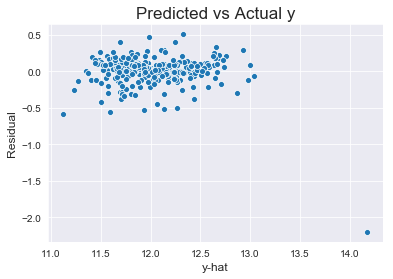

In [66]:
y_hat = grid_ridge2.predict(X_wecon_test)
sns.scatterplot(y_hat, y_test-y_hat)
plt.ylabel('Residual', fontsize=12)
plt.xlabel('y-hat', fontsize=12)
plt.title('Predicted vs Actual y', fontsize=17);

There is not any strong pattern to the residuals. The model isn't missing any fundamental patterns. There is one extreme outlier which is probably causing the reduced score on the test set.

## Use Nested Cross Validation to test Model Selection 

In [85]:
ridge_inner = Ridge()
params_cv=dict(alpha=alphas)
ridge_cv = GridSearchCV(estimator=ridge_inner, param_grid=params_cv, cv=7)
nested_scores = cross_validate(estimator=ridge_cv, X=X, y=y, cv=4, n_jobs=-1, return_estimator=True)
print('Test scores are: {}'.format(nested_scores['test_score']))
print('Estimator Values are: {}'.format(nested_scores['estimator']))

Test scores are: [0.84574242 0.82105567 0.81755027 0.7556551 ]
Estimator Values are: (GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0), GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-0

The same lambda values were chosen for each run which is a good sign that model selection is not overfitting. There is some variability to the score but not a large amount.